In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import statsmodels.api as sm

df2013 = pd.read_csv('/Users/emily/Desktop/CAPSTONE/model/2013_bootstrap_similarities.csv')
print(df2013)
df2014 = pd.read_csv('/Users/emily/Desktop/CAPSTONE/model/2014_bootstrap_similarities.csv')
print(df2014)
df2015 = pd.read_csv('/Users/emily/Desktop/CAPSTONE/model/2015_bootstrap_similarities.csv')
print(df2015)
df2016 = pd.read_csv('/Users/emily/Desktop/CAPSTONE/model/2016_bootstrap_similarities.csv')
print(df2016)
df2017 = pd.read_csv('/Users/emily/Desktop/CAPSTONE/model/2017_bootstrap_similarities.csv')
print(df2017)
df2018 = pd.read_csv('/Users/emily/Desktop/CAPSTONE/model/2018_bootstrap_similarities.csv')
print(df2018)
df2019 = pd.read_csv('/Users/emily/Desktop/CAPSTONE/model/2019_bootstrap_similarities.csv')
print(df2019)
df2020 = pd.read_csv('/Users/emily/Desktop/CAPSTONE/model/2020_bootstrap_similarities.csv')
print(df2020)

                   base      target              seed     score
0            metastatic  palliative  w2v_377623.model  0.219147
1            metastatic    palliate  w2v_377623.model  0.150753
2            metastatic  palliation  w2v_377623.model  0.210799
3            metastatic        pall  w2v_377623.model  0.067671
4     widely_metastatic  palliative  w2v_377623.model  0.210219
...                 ...         ...               ...       ...
3995    oligometastatic        pall  w2v_893172.model  0.025266
3996   nodal_metastasis  palliative  w2v_893172.model  0.135667
3997   nodal_metastasis    palliate  w2v_893172.model  0.026708
3998   nodal_metastasis  palliation  w2v_893172.model  0.165431
3999   nodal_metastasis        pall  w2v_893172.model  0.004433

[4000 rows x 4 columns]
                   base      target              seed     score
0            metastatic  palliative  w2v_266494.model  0.228396
1            metastatic    palliate  w2v_266494.model  0.231980
2            me

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('../input/train.csv').sample(50000, random_state=23)

## Calculate PWA for pall

In [2]:

base_values = ["metastatic", "widely_metastatic", "metastasis", "mets", "osseous_metastatic", "metastasized",
               "metastasis", "metastasize", "oligometastatic", "nodal_metastasis"]
target_values = ['pall']

result_dict = {}

for year in range(2013, 2021):
    file_path = f"/Users/emily/Desktop/CAPSTONE/model/{year}_bootstrap_similarities.csv"
    df = pd.read_csv(file_path)
    df = df[df['base'].isin(base_values) & df['target'].isin(target_values)]
    df_result = df.groupby(['base', 'target']).agg(
        cosine_similarity=('score', 'mean'),
        sdk=('score', 'std')
    ).reset_index()
    df_result['ak'] = 1 / df_result['sdk']**2
    df_result['ak_cosine_similarity'] = df_result['cosine_similarity'] * df_result['ak']
    cosine_similarity = df_result['ak_cosine_similarity'].sum() / df_result['ak'].sum()
    result_dict[str(year)] = {'cosine_similarity': cosine_similarity}

result_df = pd.DataFrame(result_dict).transpose().reset_index()
result_df.columns = ['Year', 'cosine_similarity']
result_df['Year'] = pd.to_numeric(result_df['Year'])

# Print out the resulting DataFrame to see the cosine similarity for each year
print(result_df)


   Year  cosine_similarity
0  2013           0.036399
1  2014           0.035071
2  2015           0.020434
3  2016           0.020822
4  2017           0.045990
5  2018           0.048029
6  2019           0.032648
7  2020           0.028242


## cosine similarity between metastatics group and pall

                            OLS Regression Results                            
Dep. Variable:      cosine_similarity   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.152
Method:                 Least Squares   F-statistic:                   0.07588
Date:                Mon, 03 Jun 2024   Prob (F-statistic):              0.792
Time:                        15:46:47   Log-Likelihood:                 25.578
No. Observations:                   8   AIC:                            -47.16
Df Residuals:                       6   BIC:                            -47.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9452      3.554     -0.266      0.7

/Users/emily/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


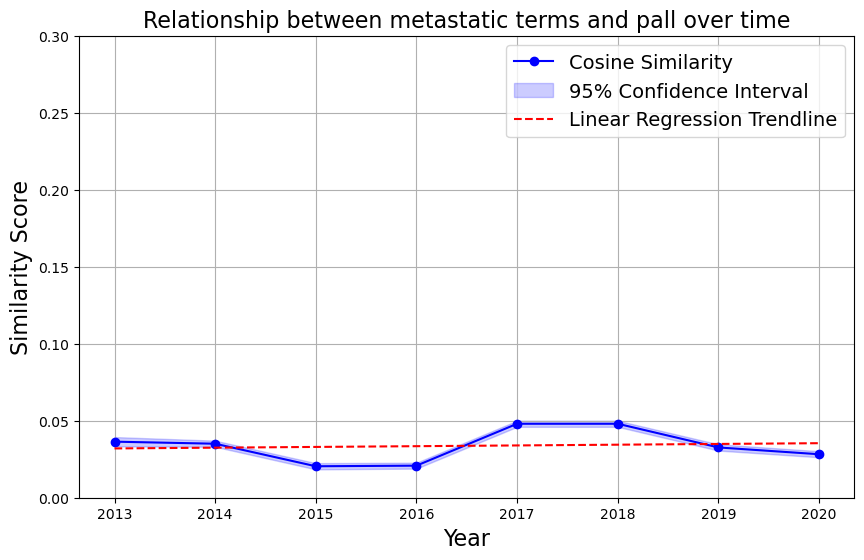

In [3]:
original_scores = {
    2013: 0.036399, 2014: 0.035071, 2015: 0.020434, 2016: 0.020822,
    2017: 0.048029, 2018: 0.048029, 2019: 0.032648, 2020: 0.028242
}
result_dict = {}

for year in range(2013, 2021):
    file_path = f"/Users/emily/Desktop/CAPSTONE/model/{year}_bootstrap_similarities.csv"
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df = df[df['base'].isin(base_values) & df['target'].isin(target_values)]
        sdk = df['score'].std()  
        cosine_similarity = original_scores[year] 
        se = sdk / np.sqrt(len(df)) 
        result_dict[str(year)] = {
            'Year': year,
            'cosine_similarity': cosine_similarity,
            'se': se,
            'ci_lower': cosine_similarity - 1.96 * se,
            'ci_upper': cosine_similarity + 1.96 * se
        }
    else:
        print(f"File not found for the year {year}: {file_path}")

# Converting the result_dict to a DataFrame
result_df = pd.DataFrame.from_dict(result_dict, orient='index')
X = sm.add_constant(result_df['Year'])
y = result_df['cosine_similarity']

# Fit the regression model
model = sm.OLS(y, X).fit()
print(model.summary())
x_values = np.linspace(result_df['Year'].min(), result_df['Year'].max(), 100)
y_values = model.predict(sm.add_constant(x_values))

plt.figure(figsize=(10, 6))
plt.plot(result_df['Year'], result_df['cosine_similarity'], marker='o', linestyle='-', color='blue', label='Cosine Similarity')
plt.fill_between(result_df['Year'], result_df['ci_lower'], result_df['ci_upper'], color='blue', alpha=0.2, label='95% Confidence Interval')
plt.plot(x_values, y_values, 'r--', label='Linear Regression Trendline')
plt.title('Relationship between metastatic terms and pall over time',fontsize=16)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Similarity Score',fontsize=16)
plt.xticks(result_df['Year'].unique())
plt.grid(True)
plt.ylim(0, 0.3) 
plt.legend(fontsize=14)
plt.show()

## Calculate PWA for palliative

In [4]:

base_values = ["metastatic", "widely_metastatic", "metastasis", "mets", "osseous_metastatic", "metastasized",
               "metastasis", "metastasize", "oligometastatic", "nodal_metastasis"]
target_values = ['palliative']

result_dict = {}

for year in range(2013, 2021):
    file_path = f"/Users/emily/Desktop/CAPSTONE/model/{year}_bootstrap_similarities.csv"
    df = pd.read_csv(file_path)
    df = df[df['base'].isin(base_values) & df['target'].isin(target_values)]
    df_result = df.groupby(['base', 'target']).agg(
        cosine_similarity=('score', 'mean'),
        sdk=('score', 'std')
    ).reset_index()
    df_result['ak'] = 1 / df_result['sdk']**2
    df_result['ak_cosine_similarity'] = df_result['cosine_similarity'] * df_result['ak']
    cosine_similarity = df_result['ak_cosine_similarity'].sum() / df_result['ak'].sum()
    result_dict[str(year)] = {'cosine_similarity': cosine_similarity}

result_df = pd.DataFrame(result_dict).transpose().reset_index()
result_df.columns = ['Year', 'cosine_similarity']
result_df['Year'] = pd.to_numeric(result_df['Year'])

# Print out the resulting DataFrame to see the cosine similarity for each year
print(result_df)

   Year  cosine_similarity
0  2013           0.171312
1  2014           0.153975
2  2015           0.148865
3  2016           0.148750
4  2017           0.147520
5  2018           0.147882
6  2019           0.156465
7  2020           0.143670


## cosine similarity between metastatics group and palliative

                            OLS Regression Results                            
Dep. Variable:      cosine_similarity   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     3.845
Date:                Mon, 03 Jun 2024   Prob (F-statistic):             0.0976
Time:                        15:49:18   Log-Likelihood:                 29.172
No. Observations:                   8   AIC:                            -54.34
Df Residuals:                       6   BIC:                            -54.19
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5988      2.268      2.028      0.0

/Users/emily/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


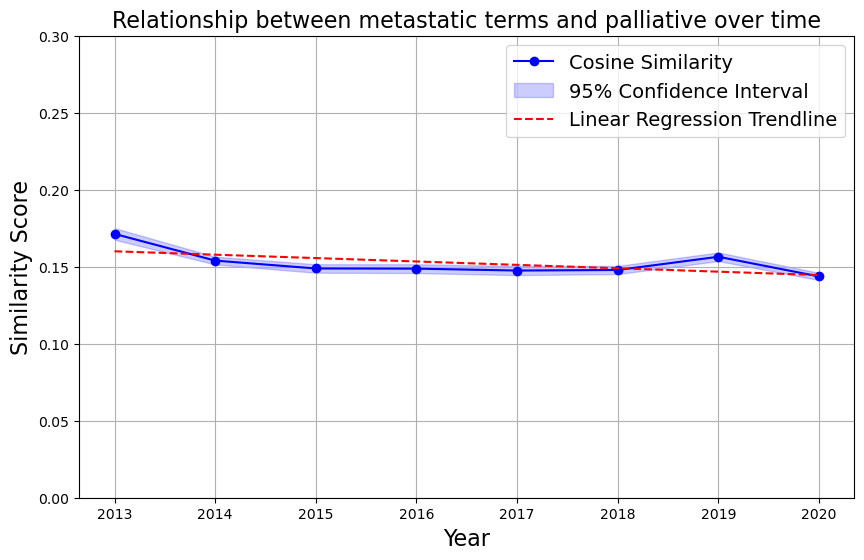

In [5]:
original_scores = {
    2013: 0.171312, 2014: 0.153975, 2015: 0.148865, 2016: 0.148750,
    2017: 0.147520, 2018: 0.147882, 2019: 0.156465, 2020: 0.143670
}
result_dict = {}

for year in range(2013, 2021):
    file_path = f"/Users/emily/Desktop/CAPSTONE/model/{year}_bootstrap_similarities.csv"
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df = df[df['base'].isin(base_values) & df['target'].isin(target_values)]
        sdk = df['score'].std()  
        cosine_similarity = original_scores[year] 
        se = sdk / np.sqrt(len(df)) 
        result_dict[str(year)] = {
            'Year': year,
            'cosine_similarity': cosine_similarity,
            'se': se,
            'ci_lower': cosine_similarity - 1.96 * se,
            'ci_upper': cosine_similarity + 1.96 * se
        }
    else:
        print(f"File not found for the year {year}: {file_path}")

# Converting the result_dict to a DataFrame
result_df = pd.DataFrame.from_dict(result_dict, orient='index')
X = sm.add_constant(result_df['Year'])
y = result_df['cosine_similarity']

# Fit the regression model
model = sm.OLS(y, X).fit()
print(model.summary())
x_values = np.linspace(result_df['Year'].min(), result_df['Year'].max(), 100)
y_values = model.predict(sm.add_constant(x_values))

plt.figure(figsize=(10, 6))
plt.plot(result_df['Year'], result_df['cosine_similarity'], marker='o', linestyle='-', color='blue', label='Cosine Similarity')
plt.fill_between(result_df['Year'], result_df['ci_lower'], result_df['ci_upper'], color='blue', alpha=0.2, label='95% Confidence Interval')
plt.plot(x_values, y_values, 'r--', label='Linear Regression Trendline')
plt.title('Relationship between metastatic terms and palliative over time',fontsize=16)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Similarity Score',fontsize=16)
plt.xticks(result_df['Year'].unique())
plt.grid(True)
plt.ylim(0, 0.3) 
plt.legend(fontsize=14)
plt.show()

## Calculate PWA for palliative

In [7]:

base_values = ["metastatic", "widely_metastatic", "metastasis", "mets", "osseous_metastatic", "metastasized",
               "metastasis", "metastasize", "oligometastatic", "nodal_metastasis"]
target_values = ['palliate']

result_dict = {}

for year in range(2013, 2021):
    file_path = f"/Users/emily/Desktop/CAPSTONE/model/{year}_bootstrap_similarities.csv"
    df = pd.read_csv(file_path)
    df = df[df['base'].isin(base_values) & df['target'].isin(target_values)]
    df_result = df.groupby(['base', 'target']).agg(
        cosine_similarity=('score', 'mean'),
        sdk=('score', 'std')
    ).reset_index()
    df_result['ak'] = 1 / df_result['sdk']**2
    df_result['ak_cosine_similarity'] = df_result['cosine_similarity'] * df_result['ak']
    cosine_similarity = df_result['ak_cosine_similarity'].sum() / df_result['ak'].sum()
    result_dict[str(year)] = {'cosine_similarity': cosine_similarity}

result_df = pd.DataFrame(result_dict).transpose().reset_index()
result_df.columns = ['Year', 'cosine_similarity']
result_df['Year'] = pd.to_numeric(result_df['Year'])

# Print out the resulting DataFrame to see the cosine similarity for each year
print(result_df)

   Year  cosine_similarity
0  2013           0.069979
1  2014           0.100197
2  2015           0.065813
3  2016           0.046110
4  2017           0.066363
5  2018           0.060823
6  2019           0.053083
7  2020           0.060476


## cosine similarity between metastatics group and palliate

                            OLS Regression Results                            
Dep. Variable:      cosine_similarity   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     2.463
Date:                Mon, 03 Jun 2024   Prob (F-statistic):              0.168
Time:                        15:50:46   Log-Likelihood:                 23.618
No. Observations:                   8   AIC:                            -43.24
Df Residuals:                       6   BIC:                            -43.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1905      4.540      1.584      0.1

/Users/emily/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


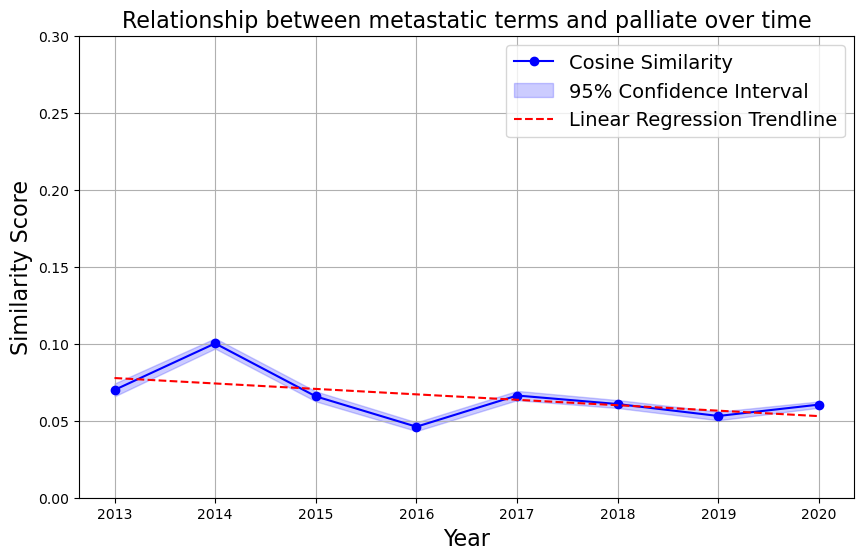

In [8]:
original_scores = {
    2013: 0.069979, 2014: 0.100197, 2015: 0.065813, 2016: 0.046110,
    2017: 0.066363, 2018: 0.060823, 2019: 0.053083, 2020: 0.060476
}
result_dict = {}

for year in range(2013, 2021):
    file_path = f"/Users/emily/Desktop/CAPSTONE/model/{year}_bootstrap_similarities.csv"
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df = df[df['base'].isin(base_values) & df['target'].isin(target_values)]
        sdk = df['score'].std()  
        cosine_similarity = original_scores[year] 
        se = sdk / np.sqrt(len(df)) 
        result_dict[str(year)] = {
            'Year': year,
            'cosine_similarity': cosine_similarity,
            'se': se,
            'ci_lower': cosine_similarity - 1.96 * se,
            'ci_upper': cosine_similarity + 1.96 * se
        }
    else:
        print(f"File not found for the year {year}: {file_path}")

# Converting the result_dict to a DataFrame
result_df = pd.DataFrame.from_dict(result_dict, orient='index')
X = sm.add_constant(result_df['Year'])
y = result_df['cosine_similarity']

# Fit the regression model
model = sm.OLS(y, X).fit()
print(model.summary())
x_values = np.linspace(result_df['Year'].min(), result_df['Year'].max(), 100)
y_values = model.predict(sm.add_constant(x_values))

plt.figure(figsize=(10, 6))
plt.plot(result_df['Year'], result_df['cosine_similarity'], marker='o', linestyle='-', color='blue', label='Cosine Similarity')
plt.fill_between(result_df['Year'], result_df['ci_lower'], result_df['ci_upper'], color='blue', alpha=0.2, label='95% Confidence Interval')
plt.plot(x_values, y_values, 'r--', label='Linear Regression Trendline')
plt.title('Relationship between metastatic terms and palliate over time',fontsize=16)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Similarity Score',fontsize=16)
plt.xticks(result_df['Year'].unique())
plt.grid(True)
plt.ylim(0, 0.3) 
plt.legend(fontsize=14)
plt.show()

## Calculate PWA for palliation

In [9]:
base_values = ["metastatic", "widely_metastatic", "metastasis", "mets", "osseous_metastatic", "metastasized",
               "metastasis", "metastasize", "oligometastatic", "nodal_metastasis"]
target_values = ['palliation']

result_dict = {}

for year in range(2013, 2021):
    file_path = f"/Users/emily/Desktop/CAPSTONE/model/{year}_bootstrap_similarities.csv"
    df = pd.read_csv(file_path)
    df = df[df['base'].isin(base_values) & df['target'].isin(target_values)]
    df_result = df.groupby(['base', 'target']).agg(
        cosine_similarity=('score', 'mean'),
        sdk=('score', 'std')
    ).reset_index()
    df_result['ak'] = 1 / df_result['sdk']**2
    df_result['ak_cosine_similarity'] = df_result['cosine_similarity'] * df_result['ak']
    cosine_similarity = df_result['ak_cosine_similarity'].sum() / df_result['ak'].sum()
    result_dict[str(year)] = {'cosine_similarity': cosine_similarity}

result_df = pd.DataFrame(result_dict).transpose().reset_index()
result_df.columns = ['Year', 'cosine_similarity']
result_df['Year'] = pd.to_numeric(result_df['Year'])

# Print out the resulting DataFrame to see the cosine similarity for each year
print(result_df)

   Year  cosine_similarity
0  2013           0.159403
1  2014           0.175333
2  2015           0.142822
3  2016           0.129618
4  2017           0.141051
5  2018           0.108406
6  2019           0.107693
7  2020           0.110798


                            OLS Regression Results                            
Dep. Variable:      cosine_similarity   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     2.463
Date:                Mon, 03 Jun 2024   Prob (F-statistic):              0.168
Time:                        15:54:14   Log-Likelihood:                 23.618
No. Observations:                   8   AIC:                            -43.24
Df Residuals:                       6   BIC:                            -43.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1905      4.540      1.584      0.1

/Users/emily/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


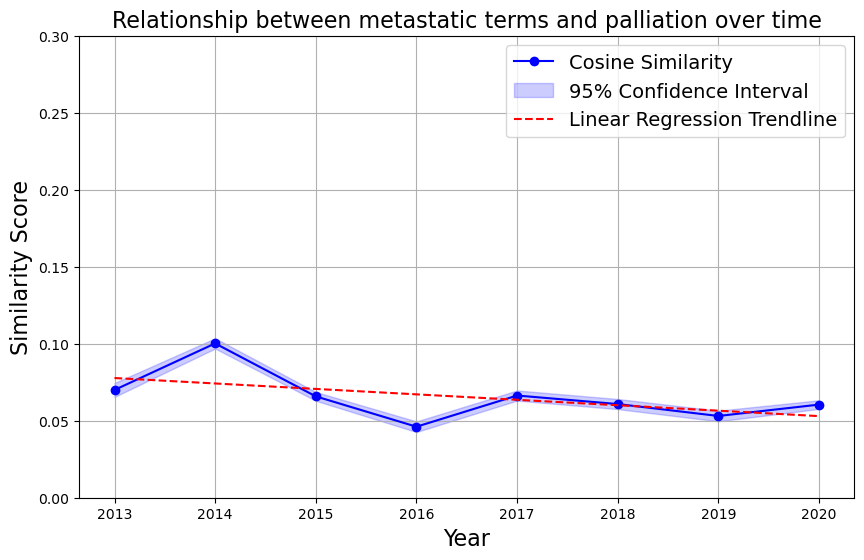

In [13]:
original_estimates = {
    '2013': 0.159403, '2014': 0.175333, '2015': 0.142822, '2016': 0.129618,
    '2017': 0.141051, '2018': 0.108406, '2019': 0.107693, '2020': 0.110798
}
result_dict = {}

for year in range(2013, 2021):
    file_path = f"/Users/emily/Desktop/CAPSTONE/model/{year}_bootstrap_similarities.csv"
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df = df[df['base'].isin(base_values) & df['target'].isin(target_values)]
        sdk = df['score'].std()  
        cosine_similarity = original_scores[year] 
        se = sdk / np.sqrt(len(df)) 
        result_dict[str(year)] = {
            'Year': year,
            'cosine_similarity': cosine_similarity,
            'se': se,
            'ci_lower': cosine_similarity - 1.96 * se,
            'ci_upper': cosine_similarity + 1.96 * se
        }
    else:
        print(f"File not found for the year {year}: {file_path}")

# Converting the result_dict to a DataFrame
result_df = pd.DataFrame.from_dict(result_dict, orient='index')
X = sm.add_constant(result_df['Year'])
y = result_df['cosine_similarity']

# Fit the regression model
model = sm.OLS(y, X).fit()
print(model.summary())
x_values = np.linspace(result_df['Year'].min(), result_df['Year'].max(), 100)
y_values = model.predict(sm.add_constant(x_values))

plt.figure(figsize=(10, 6))
plt.plot(result_df['Year'], result_df['cosine_similarity'], marker='o', linestyle='-', color='blue', label='Cosine Similarity')
plt.fill_between(result_df['Year'], result_df['ci_lower'], result_df['ci_upper'], color='blue', alpha=0.2, label='95% Confidence Interval')
plt.plot(x_values, y_values, 'r--', label='Linear Regression Trendline')
plt.title('Relationship between metastatic terms and palliation over time',fontsize=16)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Similarity Score',fontsize=16)
plt.xticks(result_df['Year'].unique())
plt.grid(True)
plt.ylim(0, 0.3) 
plt.legend(fontsize=14)
plt.show()